# Swimmers Plot for patient data and therapy events 

In [9]:
#import Libraries and set pandas options 

import pandas as pd
import numpy as np
pd.set_option('display.max_row', 1000)

## Data Load  
The data is spread over two datasheets.
- #### patient datasheet holding the detailed patient informations 
    - **Expected Columns:** (names may varry and need to configurd if needed)
        - patient_id _-> unique identifier of a repective patient_
        - Therapiesequenz_1 _-> Treatment group (cohort) within the study_
        - DATUM_ERSTE_PROGRESSION -> Day the record for a patient starts
        - date -> date of the patients status change


- #### an event datasheet holding treatment and surgery informations
    - **Expected Columns:** (names may varry and need to configurd if needed)
        - patient_id           _-> unique identifier of a repective patient_
        - Therapiesequenz_1    _-> Treatment group (cohort) within the study_
        - Treatment            _-> (eg. surgery, med.chemotherapy)_
        - treatment_date_start _-> begin of the treamtment_
        - treatment_date_stop  _-> end of the respective treatment_

In [10]:
# load the patient dataframe 
df_p = pd.read_csv(
    '01_patients.csv', 
    sep = ';'
)

In [11]:
# load the event dataframe
df_events = pd.read_csv(
    '01_events.csv', 
    sep = ';'
)

___
___
## data cleansing and normalisation
Datasets are typically don't directly formatted for automated processing, this is due to the \
duality of sientific datasets, serving as working document and data storrage. \
Operations to prepare the dataset for automated processing are summarized under data cleansing and normalisation 


### date formatting

Explicitly convert the date fields using the appropriate format string and opperations to correctly 
use datetime operations on this fields 

---

**the following cells are handeling the cleansing and normalisation operations**

In [12]:
# Replace the occuring . with an empty string 
# to avoid conversion errors
df_p = df_p.replace('.','')
df_events = df_events.replace('.','')

In [13]:
#Explicitly convert Datetimes

df_p.date.replace('', np.nan, inplace=True)
df_p['date'] = pd.to_datetime(df_p['date'], format='%d.%m.%Y')

df_p.DIAGNOSEDATUM.replace('', np.nan, inplace=True)
df_p['DIAGNOSEDATUM'] = pd.to_datetime(df_p['DIAGNOSEDATUM'], format='%d.%m.%Y')

df_p.LETZTE_INFO_DATUM.replace('', np.nan, inplace=True)
df_p['LETZTE_INFO_DATUM'] = pd.to_datetime(df_p['LETZTE_INFO_DATUM'], format='%d.%m.%Y')

df_p.DATUM_ERSTES_REZIDIV.replace('', np.nan, inplace=True)
df_p['DATUM_ERSTES_REZIDIV'] = pd.to_datetime(df_p['DATUM_ERSTES_REZIDIV'], format='%d.%m.%Y')

df_p.DATUM_ERSTE_PROGRESSION.replace('', np.nan, inplace=True)
df_p['DATUM_ERSTE_PROGRESSION'] = pd.to_datetime(df_p['DATUM_ERSTE_PROGRESSION'], format='%d.%m.%Y')


df_events.Start_Datum.replace('', np.nan, inplace=True)
df_events['start_date'] = pd.to_datetime(df_events['Start_Datum'], format='%d.%m.%Y')

df_events.Stop_Datum.replace('', np.nan, inplace=True)
df_events['end_date'] = pd.to_datetime(df_events['Stop_Datum'], format='%d.%m.%Y')

### Normalize the regimen information 
Regimen can occure in different characteristics like "1st TACE", 2nd PRRT,
for visualisation purposes only the core information TACE or PRRT is needed 
and the information about the occurance is not needed, hence discarded

In [16]:

def map_selector(unformatted_regimen:str) -> str:
    """
    this function takes the unformatted regimen string 
    and returns the normalised regimen identifier used in the 
    swimmer's plots
    """
    if 'TACE' in unformatted_regimen:
        return 'TACE'
    if 'PRRT' in unformatted_regimen:
        return 'PRRT'
    if 'Chemotherapie' in unformatted_regimen:
        return 'chemotherapy'
    if 'Chemotherapy' in unformatted_regimen:
        return 'chemotherapy'
    if 'Local Resection' in unformatted_regimen:
        return 'Local Resection'
    if 'Resection Primary Tumor' in unformatted_regimen:
        return 'Resection Primary Tumor'
    if 'Partial Liver Resection' in unformatted_regimen:
        return 'Partial Liver Resection'
    if 'Death' in unformatted_regimen:
        return 'Death'
    if 'Lost to Follow Up' in unformatted_regimen:
        return 'Lost to Follow Up'
    else:
        # if no string is recognized 
        # the dataset gets flaged to manually intervene
        raise AttributeError(unformatted_regimen)

df_events['regimen'] = df_events.apply(
      lambda row:
      map_selector(row.Therapie_1),
      axis=1
  )

### Split Data into visualizable data sets 
to split the data into sesible groups the respective therapy sequences are chosen

In [17]:
# Split patient table into Cohorts 
dict_cohorts = {}

for i in df_p.Therapiesequenz_1.unique():
    dict_cohorts[i] = df_p[df_p['Therapiesequenz_1'] == i]
    print('Therapiesequenz: ',i, 'Number of Records: ', len(dict_cohorts[i]))
    
dict_cohorts[-1] = df_p

Therapiesequenz:  0 Number of Records:  190
Therapiesequenz:  7 Number of Records:  58
Therapiesequenz:  8 Number of Records:  10
Therapiesequenz:  2 Number of Records:  46
Therapiesequenz:  1 Number of Records:  40
Therapiesequenz:  6 Number of Records:  16
Therapiesequenz:  3 Number of Records:  18


### Consider the event data set and calculate additional time range fields 

The additional field map the specific points in time on the plot axis only considering days relative to the start of the desease.   

In [18]:
# join the therapie sequence on the therapie table
# and calculate the missing fields

df_join = df_p[['patient_id_ap', 'Therapiesequenz_1','DIAGNOSEDATUM']].copy()

#create an non-index patient id copy
df_join['patient_id_p'] = df_join['patient_id_ap']
df_join = df_join.groupby('patient_id_ap').max()

merged_inner = pd.merge(left=df_join, right=df_events, left_on='patient_id_p', right_on='patient_id')

# correctly convert the date field
#df_events['Stop_Datum'] = df_events['Stop_Datum'].map({'': np.nan})
#merged_inner['end_date'] = pd.to_datetime(df_events['Stop_Datum'], format='%d.%m.%Y')

# cast the days to integer values for further processing
merged_inner['start_day'] = pd.to_numeric((merged_inner.start_date - merged_inner.DIAGNOSEDATUM).dt.days, downcast='integer')
merged_inner['duration_days'] = pd.to_numeric(((merged_inner.end_date - merged_inner.start_date)).dt.days, downcast='signed').replace(np.nan, 0)

In [19]:
# Split Events into Cohorts 
dict_events = {}

for i in merged_inner.Therapiesequenz_1.unique():
    dict_events[i] = merged_inner[merged_inner['Therapiesequenz_1'] == i]
    print('Therapiesequenz: ',i, 'Number of Records: ', len(dict_cohorts[i]))
    
dict_events[-1] = merged_inner    

Therapiesequenz:  7 Number of Records:  58
Therapiesequenz:  8 Number of Records:  10
Therapiesequenz:  2 Number of Records:  46
Therapiesequenz:  1 Number of Records:  40
Therapiesequenz:  6 Number of Records:  16
Therapiesequenz:  3 Number of Records:  18
Therapiesequenz:  0 Number of Records:  190


## Define colormaps, descriptions and legend options 

in this section the encoded values from the data tables are maped on specific colors and readable values.
The operations needed to build the legends are derived from the color and description maps and stored in list objects

In [20]:
# improvement -> use color maps 
# https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html

# Color Map describing the final patient status  
status_color = {
    0:'pink',
    1:'silver',
    2:'tan',
    3:'mediumseagreen',
    4:'cyan',
    5:'skyblue',
    6:'black',
}

# Status description of the final patient status 
status_description = {
    1:'death',
    2:'progessive disease',
    3:'complete response',
    4:'recurrance after complete remission',
    5:'partial response'
}

# Sequence groups describing the 
# individual cohorts of the retrospective study
sequence_groups = {
    1: 'TACE and/or PRRT',
    3: 'SSA and then PRRT',
    2: 'SSA',
    6: 'Chemotherapy',
    7: 'not metastasised surgery only',
    8: 'metastasised surgery only'
}

# Map for regimen and applied Marker 
# used in the visualisation
marker_map = {
    'TACE': {'marker':'o', 'color': 'black'}, 
    'PRRT': {'marker':'d', 'color': 'black'},
    'chemotherapy end unknown': {'marker':'x', 'color': 'black'},
    'chemotherapy ongoing': {'marker':'_', 'color': 'black'},
    'chemotherapy stop' : {'marker':'|', 'color': 'black'},
    'Local Resection' : {'marker':'p', 'color': 'red'},
    'Resection Primary Tumor' : {'marker':'o', 'color': 'red'},
    'Partial Liver Resection' : {'marker':'>', 'color': 'red'},
    'Death' : {'marker':'*', 'color': 'black'},
    'Lost to Follow Up' : {'marker':'*', 'color': 'red'},
}

# create the foundation for the legend

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

patches = []
for i in status_description.keys():
    patches.append(mpatches.Patch(color=status_color[i], label=status_description[i]))

regiments = []
for i in marker_map.keys():
    regiments.append(
        mlines.Line2D([], 
                      [], 
                      color=marker_map[i]['color'], 
                      marker=marker_map[i]['marker'], 
                      linestyle='None',
                      label=i,
                      markersize= 20
                     )
    )
    

## Plotting Algorithm 

### Definition of the elemets of the graph 

In [21]:
# Broken barh elements

import matplotlib.pyplot as plt
import math

# define a generic function to accept the patient data
# and bring it in to a general format

def broken_barh_element(day_start: int, day_end :int, index :int, status: int ):
    
    # xcenters = day_start + (day_end - day_start) / 2
    ax.broken_barh([(day_start, day_end - day_start - 20)], (index, 0.7), facecolors=status_color[status], linestyle='--')
    
    # ax.text(xcenters, index + 0.25, str(day_end - day_start), ha='center', va='center',color='white')

In [22]:
# Scatter Elements

def point_elemets(day_start: int, index :int, marker = "o", color = 'black'):
    
    ax.scatter(x=day_start, s=500, y=index + 0.4, marker=marker, color= color)

In [23]:
# Arrow Elements

def arrow_element(day_stop: int, day_start: int, index :int):
    ax.arrow(day_start, index + 0.4, day_stop, 0, head_width=0.5, head_length=0.01, fc='k', ec='k', width = 0.05)

### Graph construction algorithm

In [24]:
# plotting algorithm

def plot_bars(cohort: int, sort_value = None):
    
    # determine the unique index of the respective patient per cohort
    
    df = dict_cohorts[cohort]
    
    if cohort in dict_events.keys():
        dft = dict_events[cohort]
    else:
        dft = pd.DataFrame()
    
    # group by the patient ID and get the max values of all other rows 
    df_index = df.groupby('patient_id_ap').max()
    
    # if needed sort the grouped dataframe with respect to the sort_value
    if sort_value is not None:
        df_index = df_index.sort_values(by=[sort_value])
        
        
    index_dict = {}
    for pid, index in zip(df_index.index, range(0,len(df_index))):
        index_dict[pid] = index

    
    # iterate throu the rows to plot the repective values
    for index, row in df.iterrows():
        broken_barh_element(
             row['Start_Tage'] # -> starting position on the chart
            ,row['Stop_Tage'] # -> stop position on the chart
            ,index_dict[row['patient_id_ap']] # -> takte the index of the respective patient id in context to the cohort
            ,row['Endstatus'] # -> coloring in the chart
        )
        
   # iterate throu the rows to plot the repective values
    for index, row in dft.iterrows():
        # all elements except "chemotherapy" are point elements 
        if row['regimen'] is not 'chemotherapy':
            point_elemets(
                 row['start_day']
                ,index_dict[row['patient_id_p']]
                ,marker = marker_map[row['regimen']]['marker']
                ,color  = marker_map[row['regimen']]['color']
            )
        # only elements of the "chemotherapy" describe a time range
        if row['regimen'] is 'chemotherapy':
            if row['Stop_Datum'] is np.NaN:
                # if no stop date for the chemotherapy is known habdle the therapy as
                # point element to avaid unwanted behavior in the graphics
                point_elemets(
                     row['start_day']
                    ,index_dict[row['patient_id_p']]
                    ,marker = marker_map['chemotherapy end unknown']['marker']
                    ,color  = marker_map['chemotherapy end unknown']['color']
                )
            else:
                arrow_element( 
                    row['duration_days'],
                    row['start_day'],
                    index_dict[row['patient_id_p']]
                )

    # ------------------------------------- #
    # set the x axis propertis 
    # derive the max value from the actual dataframe
    xlim = dict_cohorts[cohort].loc[df['Stop_Tage'].idxmax()]['Stop_Tage']

    ax.set_xlim(0, xlim + 100)
    ax.set_xlabel('days')
    ax.set_xticks(range(0,xlim + 100,500))

    # ------------------------------------- #
    # set the y axis propertis 

    ax.set_ylabel('patient id')
    ax.set_yticks(range(0,len(index_dict),1))
    ax.set_yticklabels(df_index.index)
    #ax.set_yticklabels([])
    ax.grid(True)

    # ------------------------------------- #

### Build Graphs  

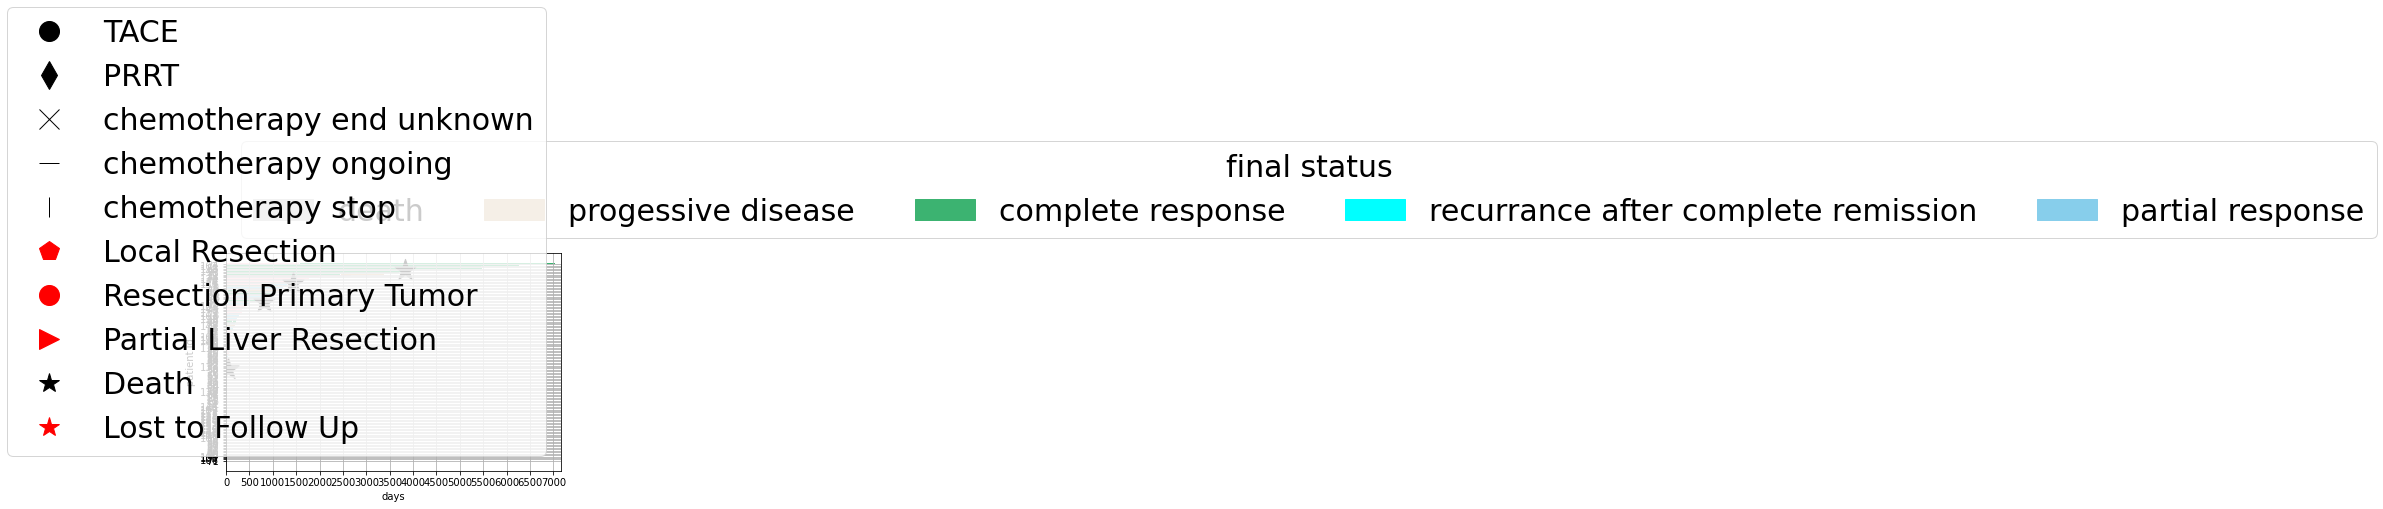

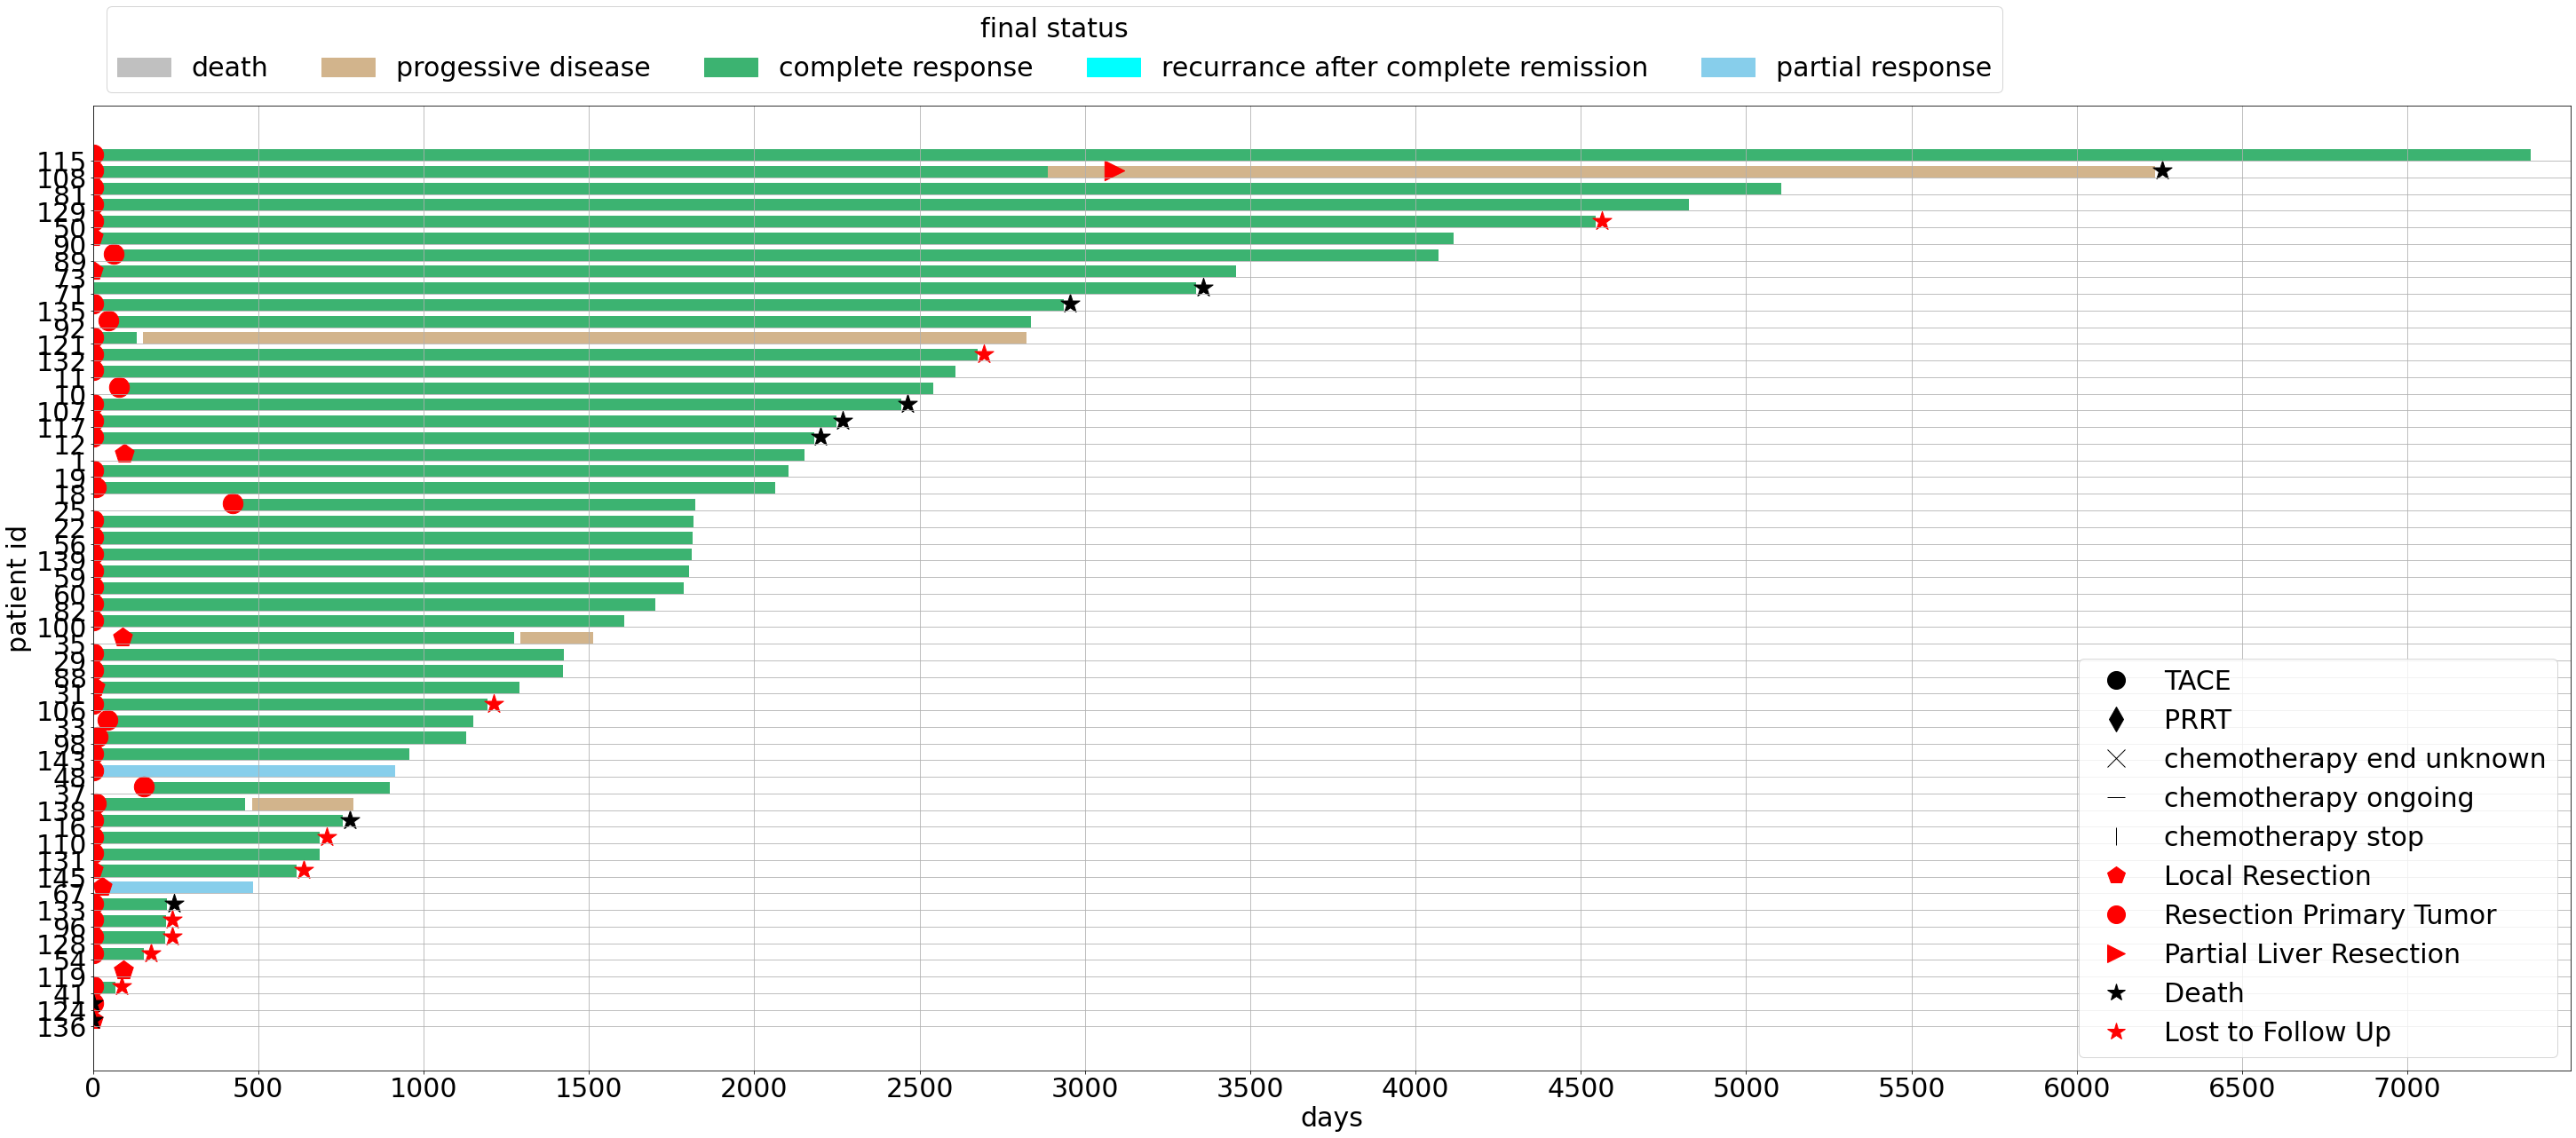

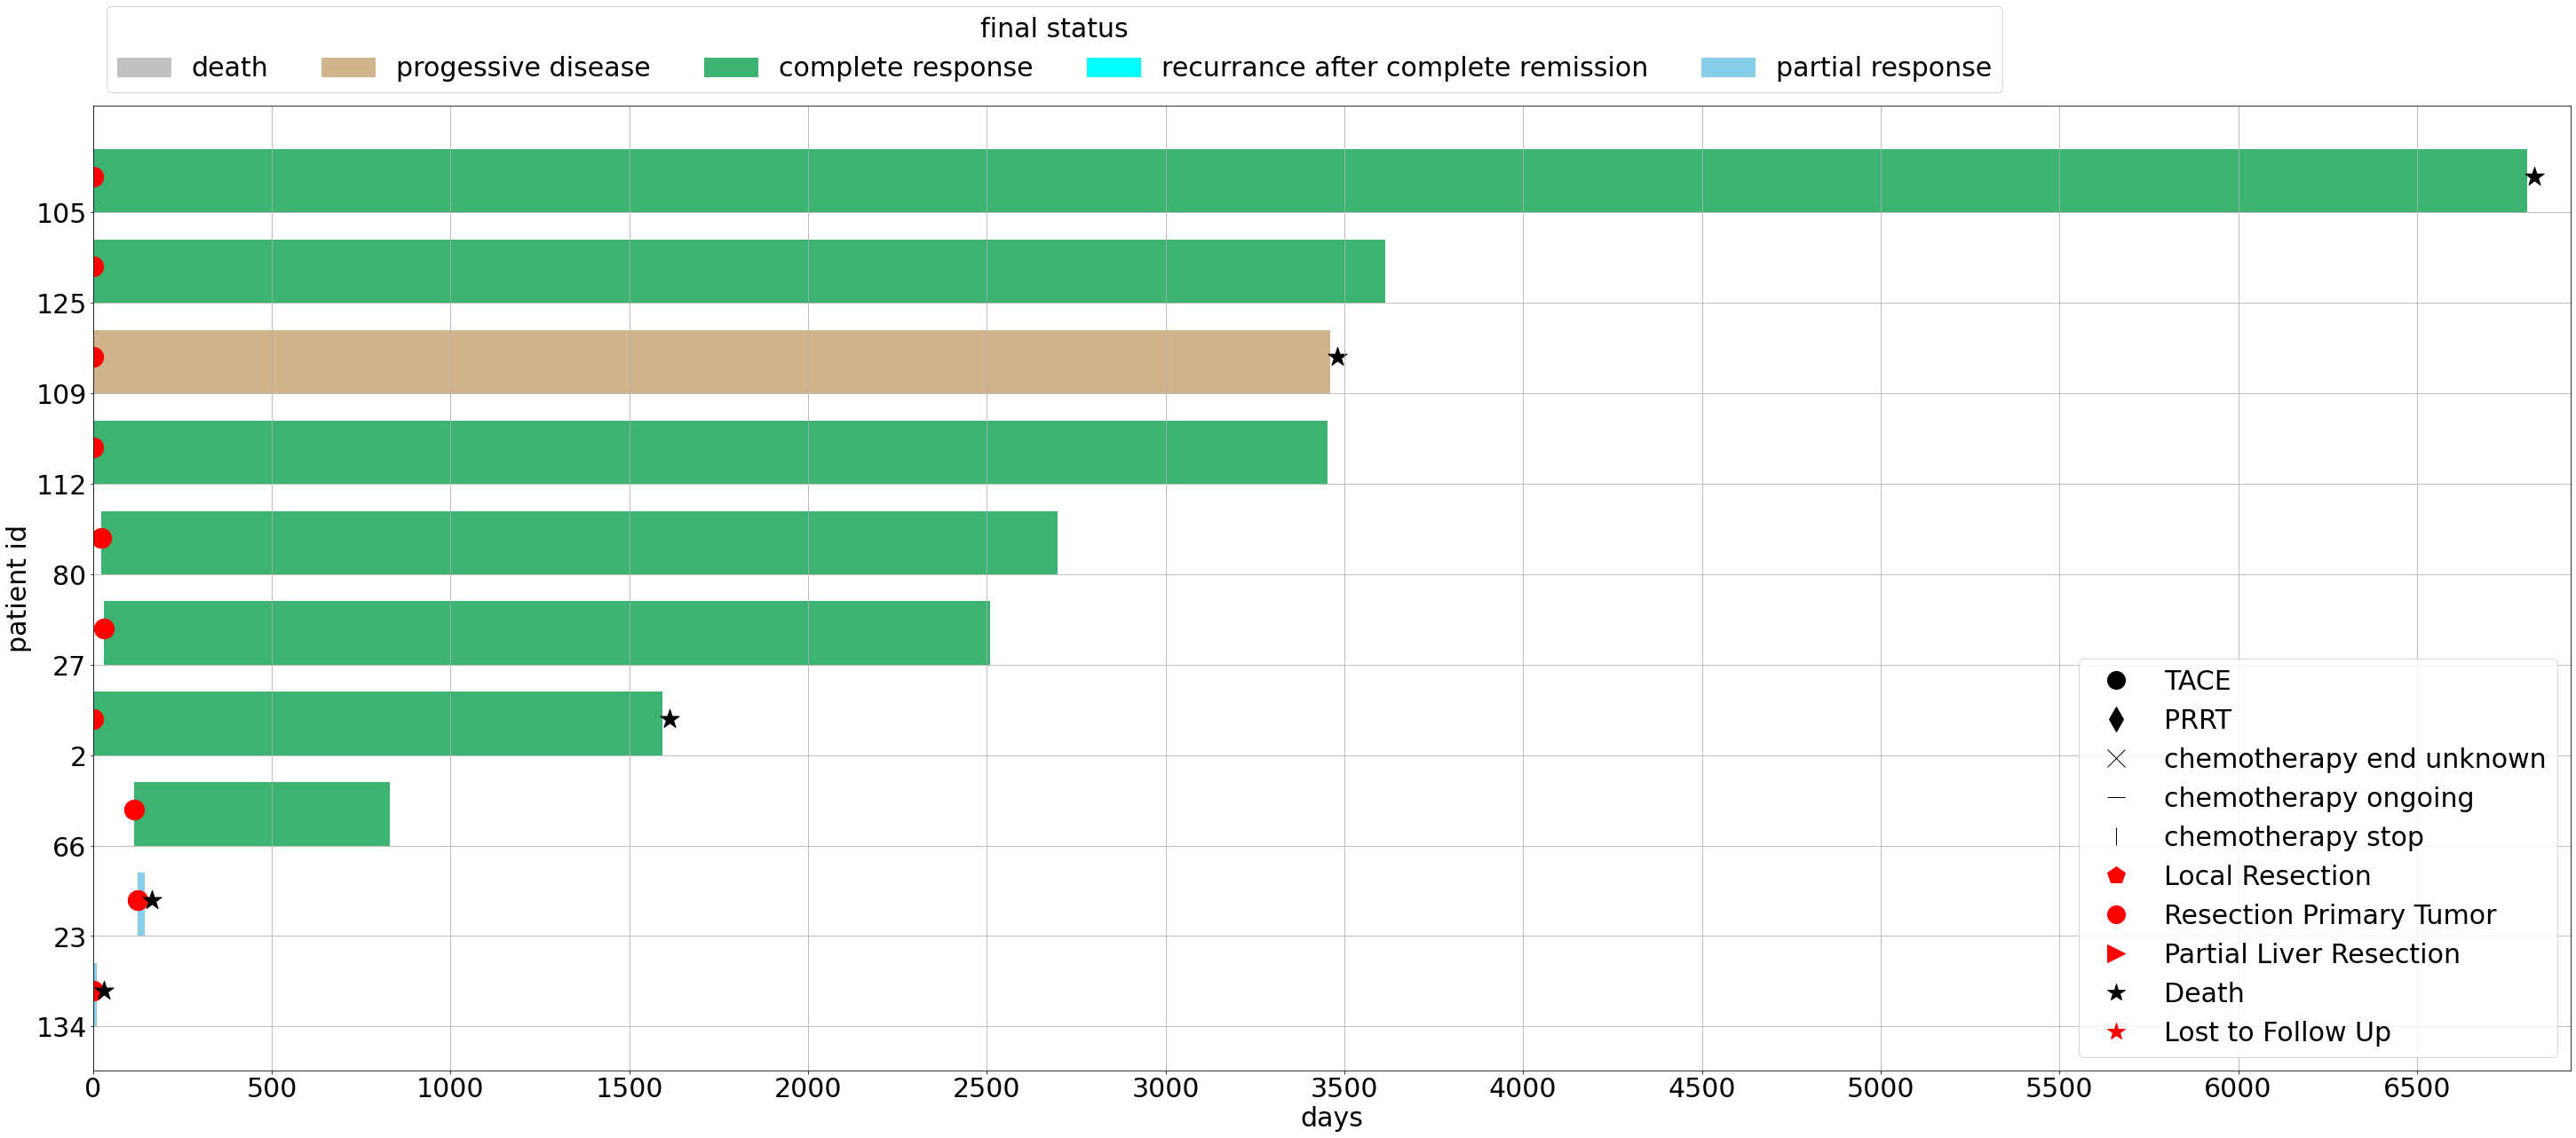

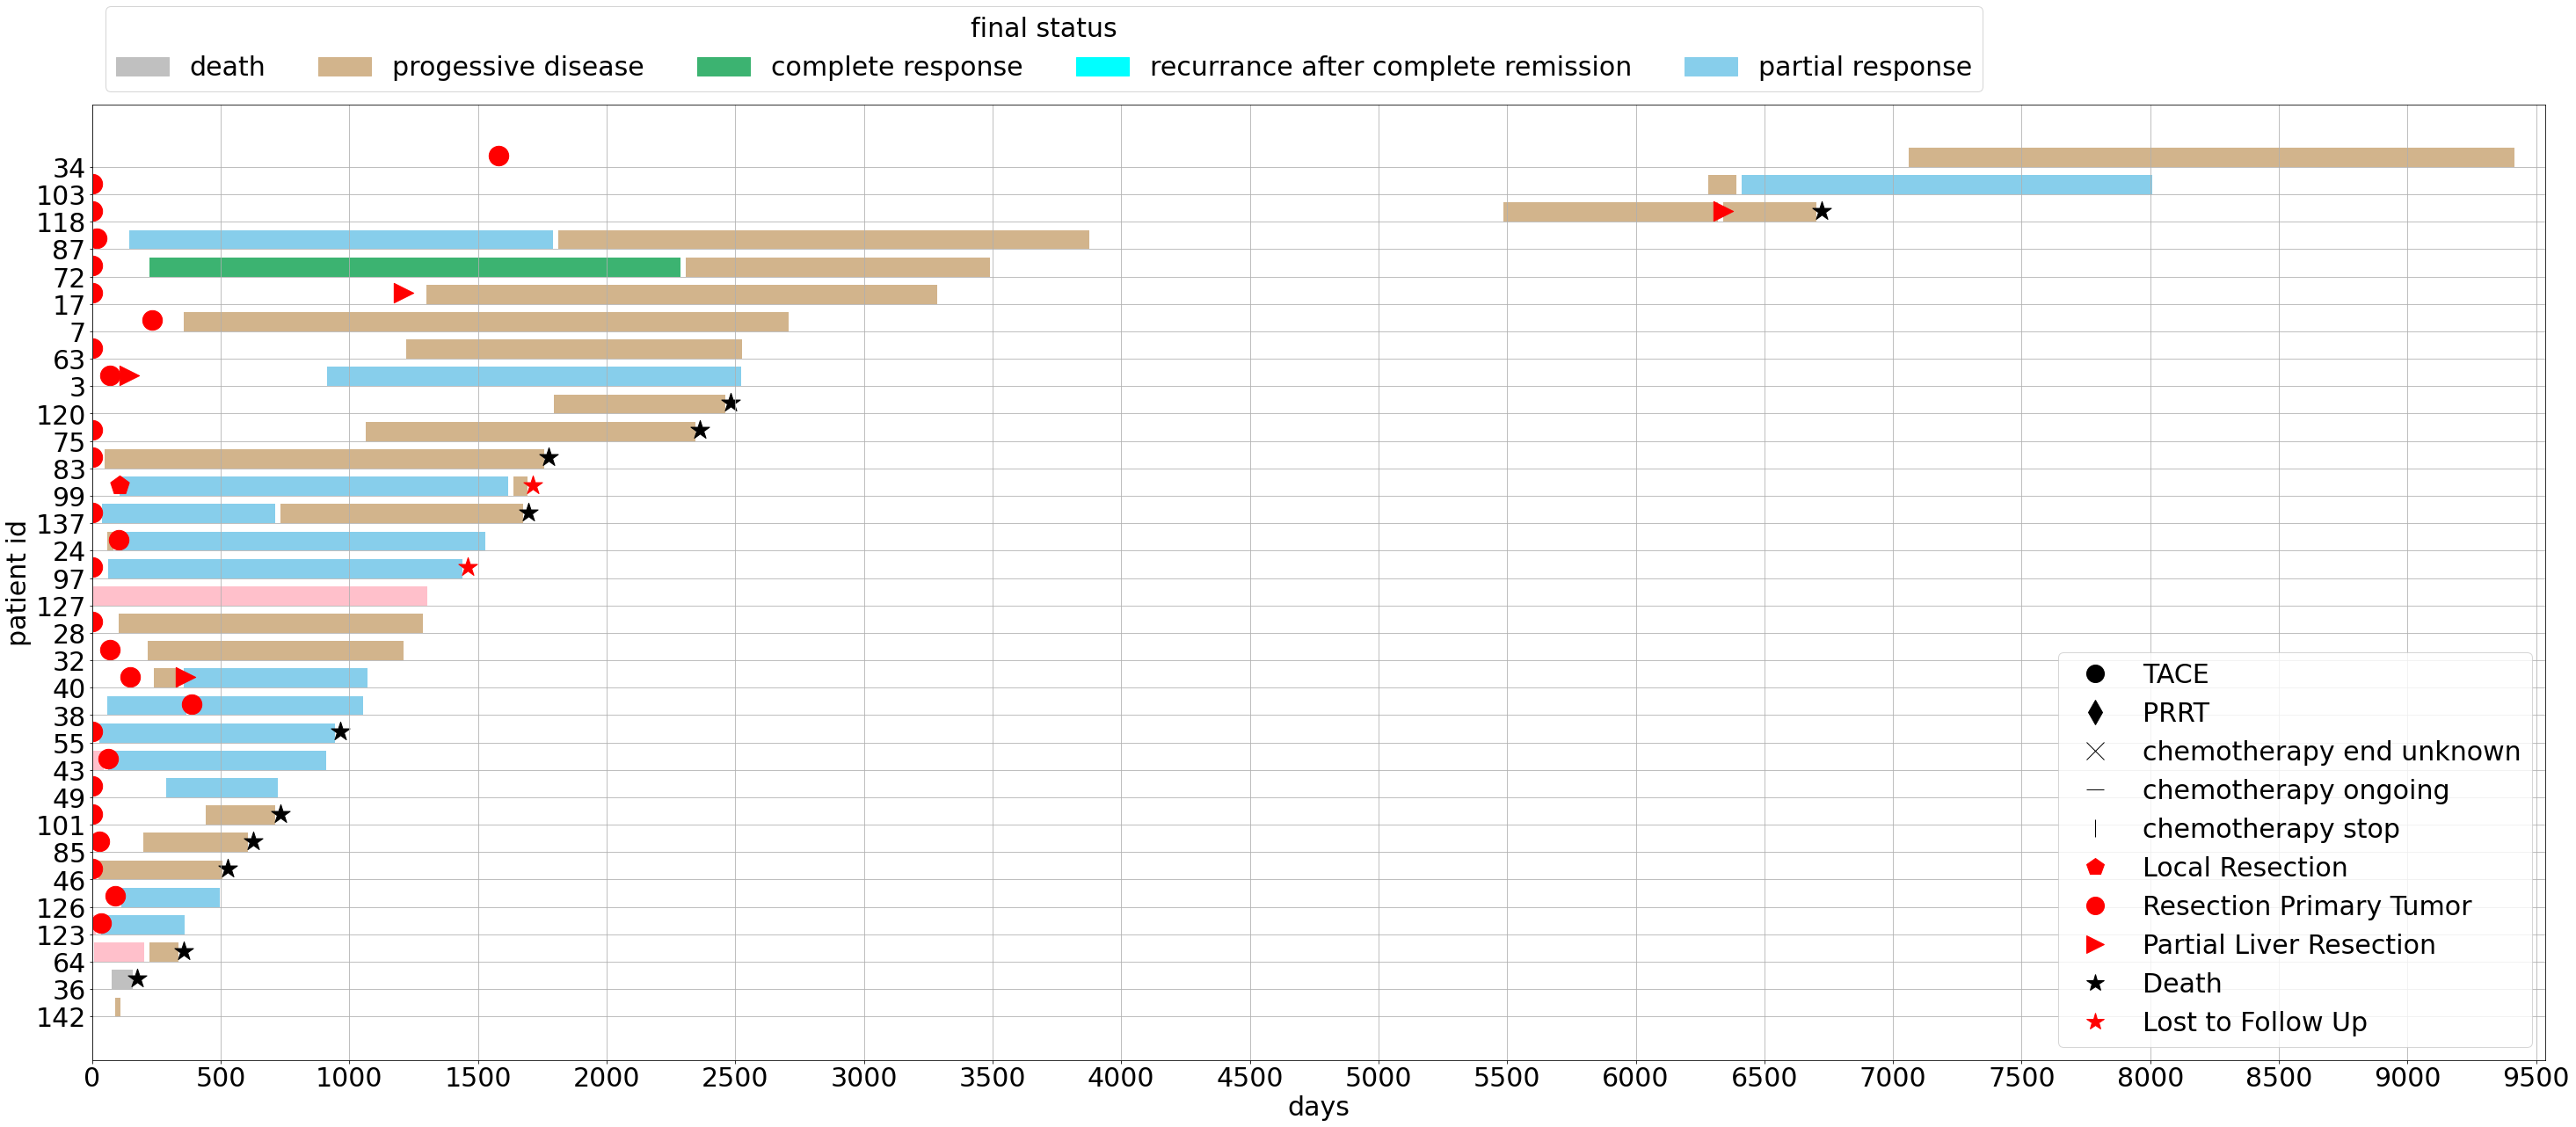

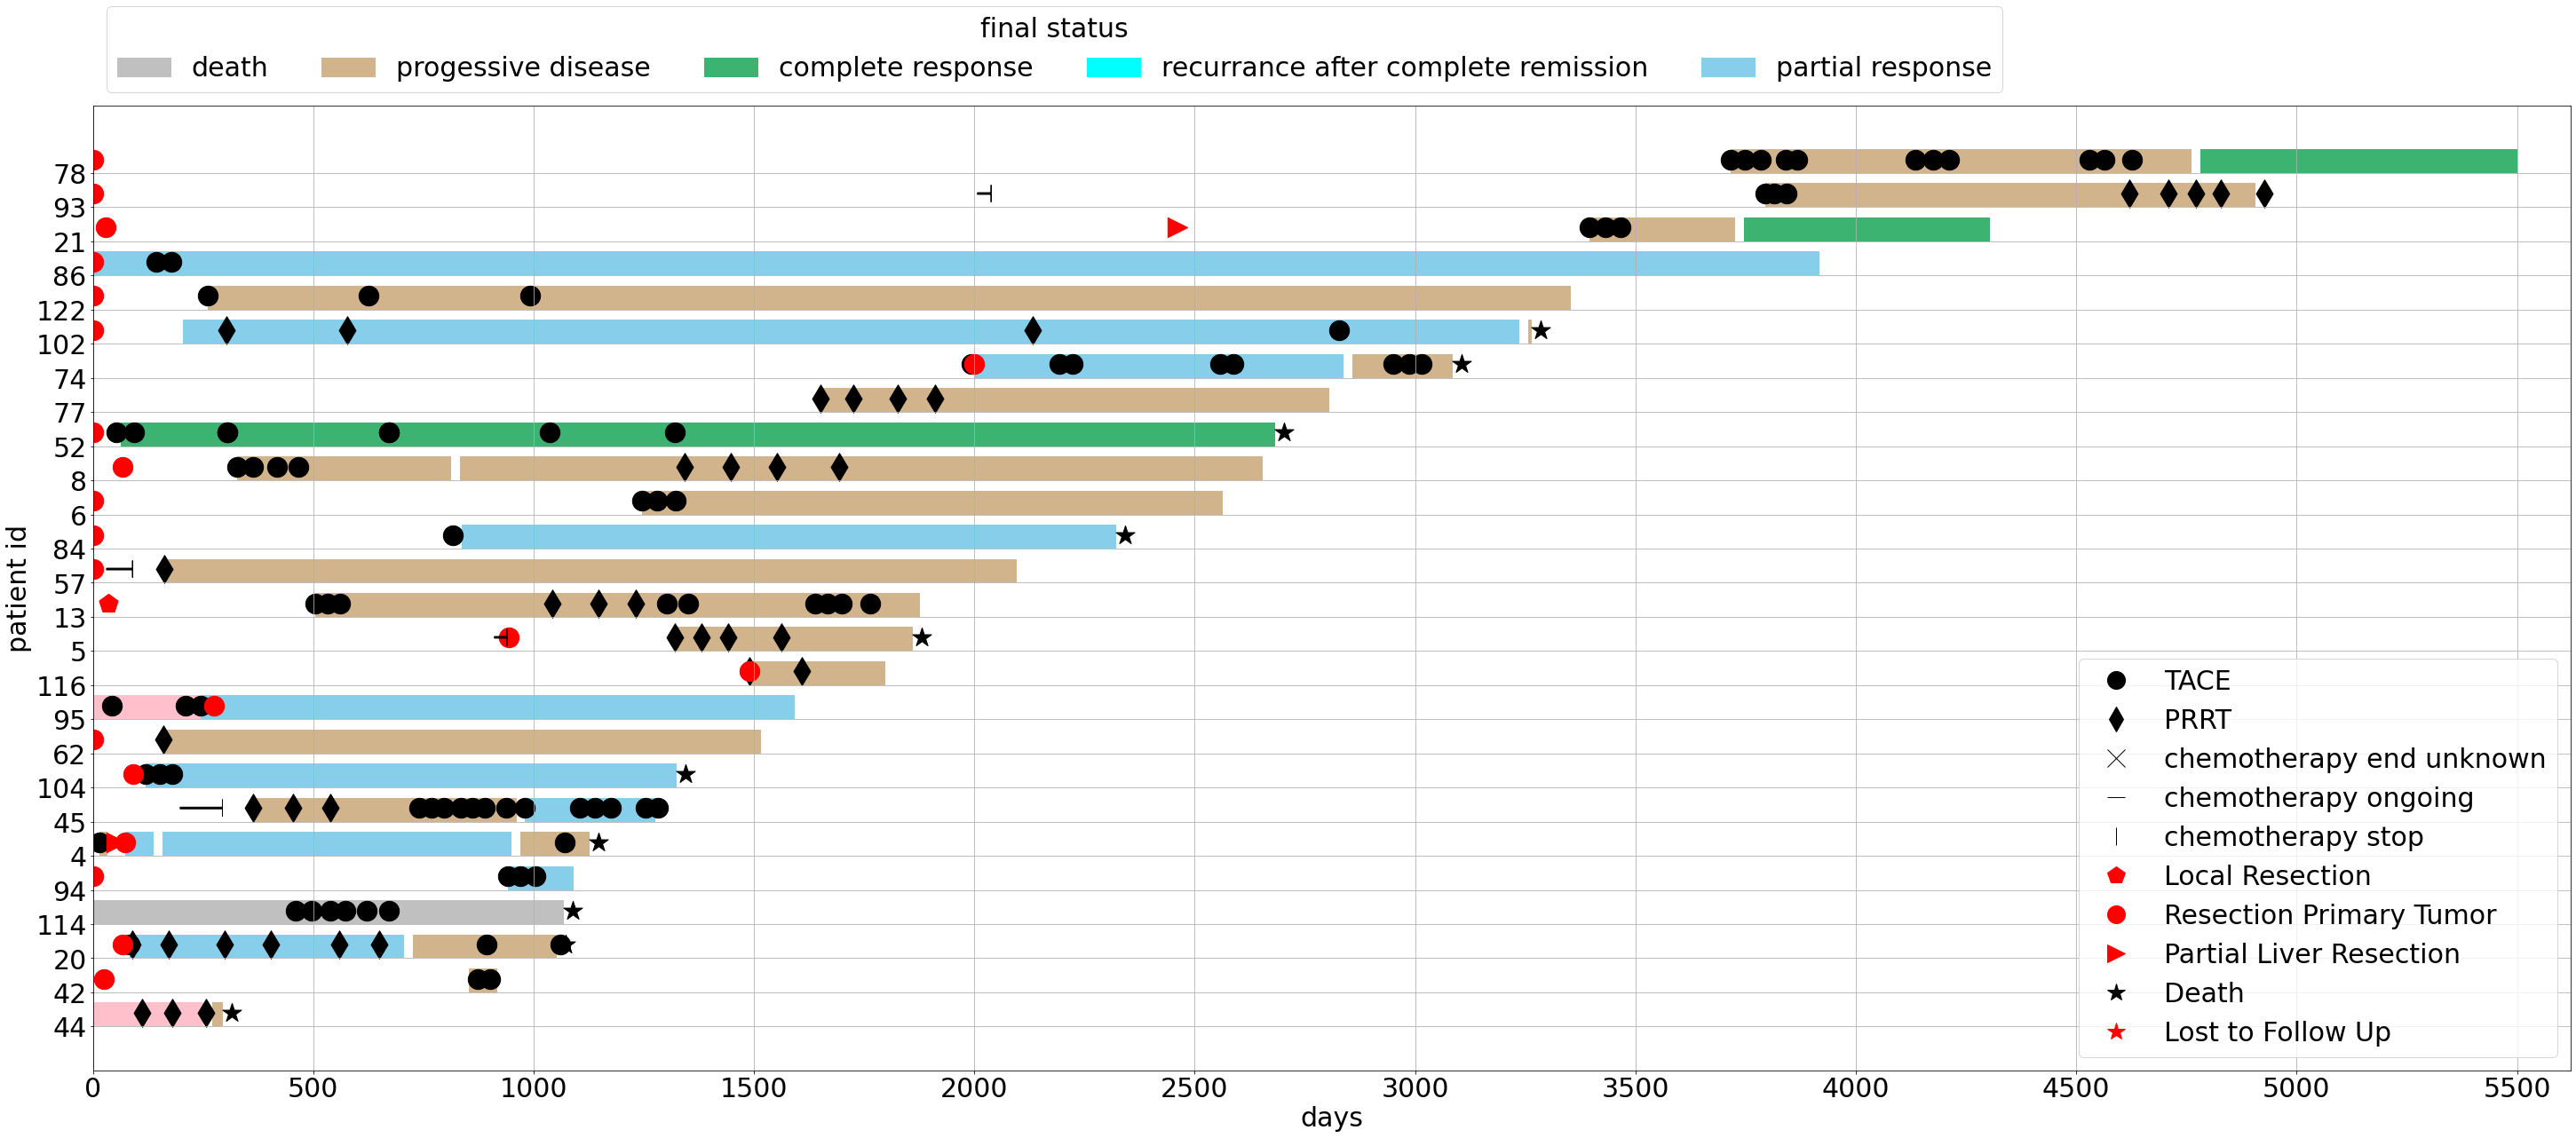

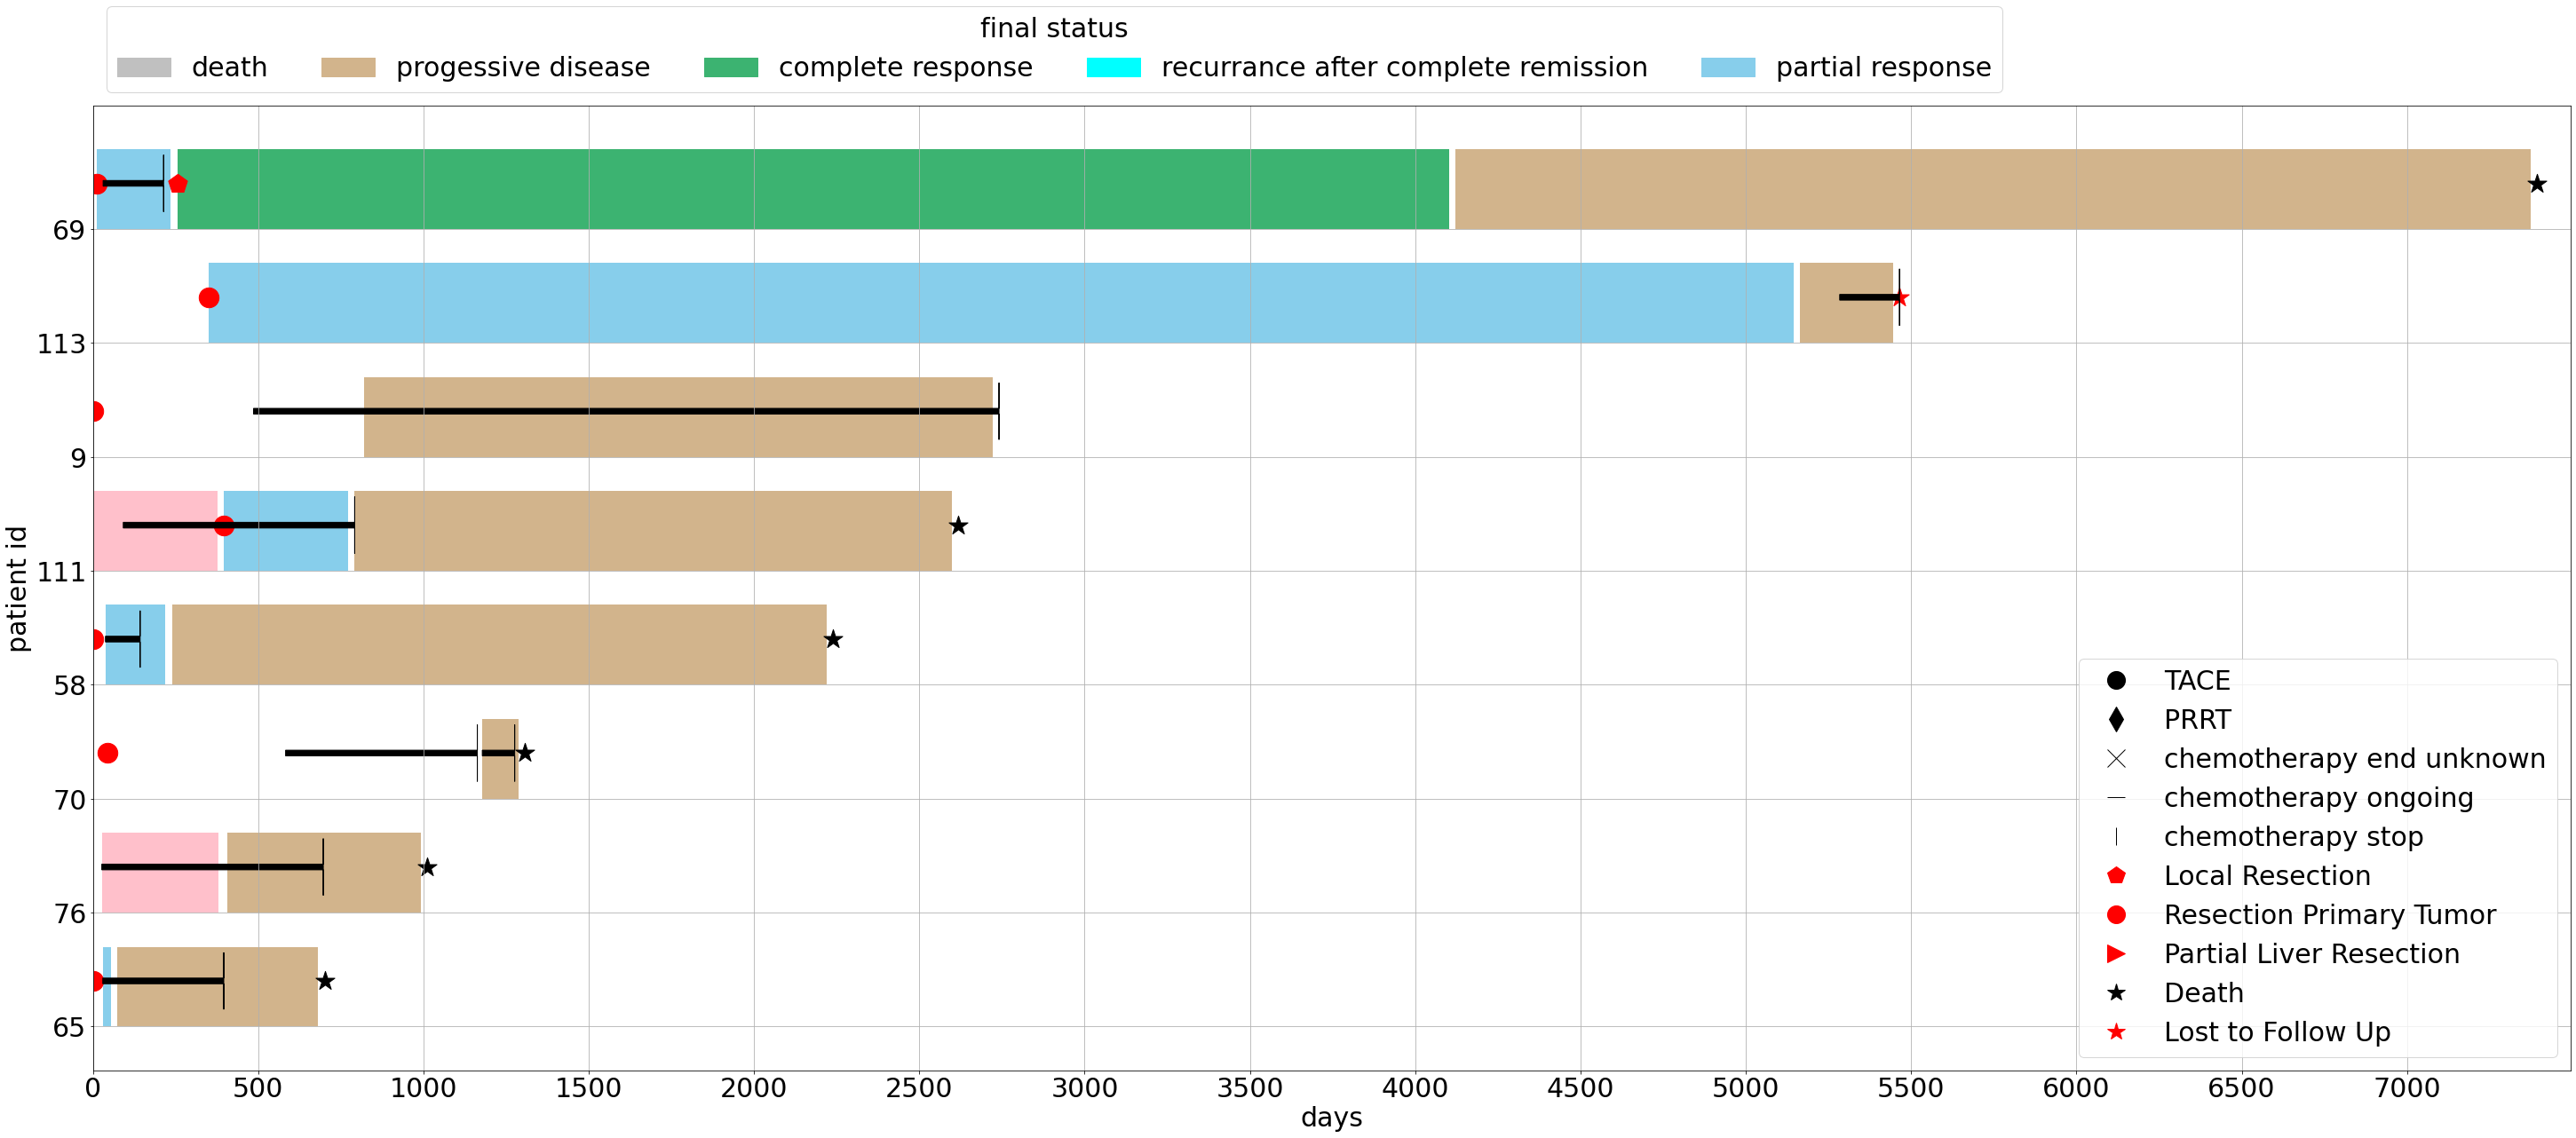

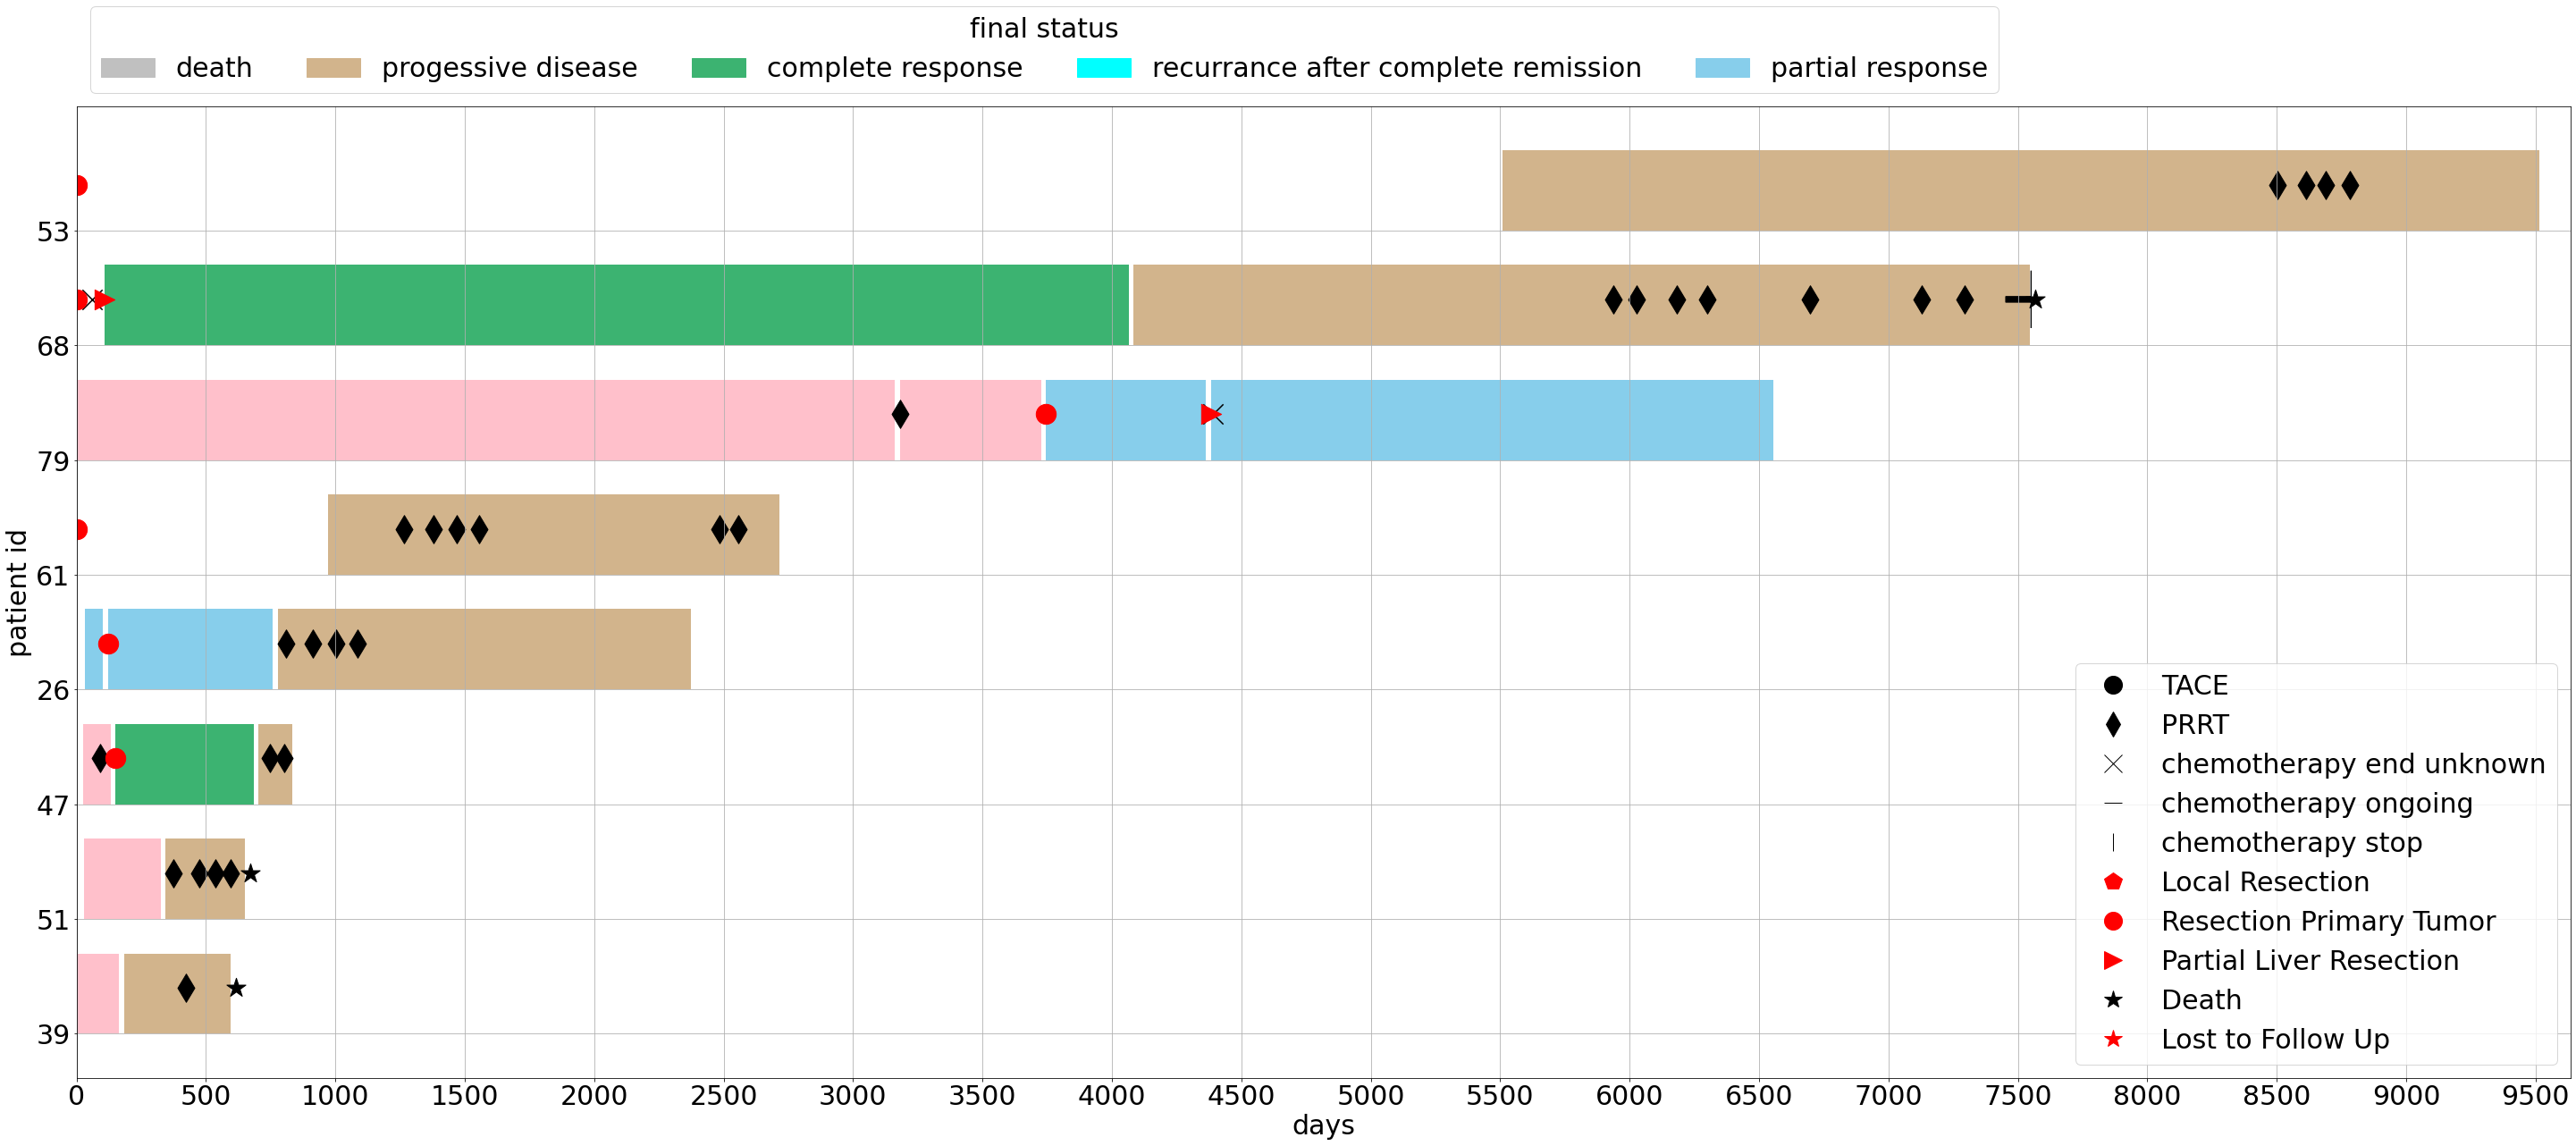

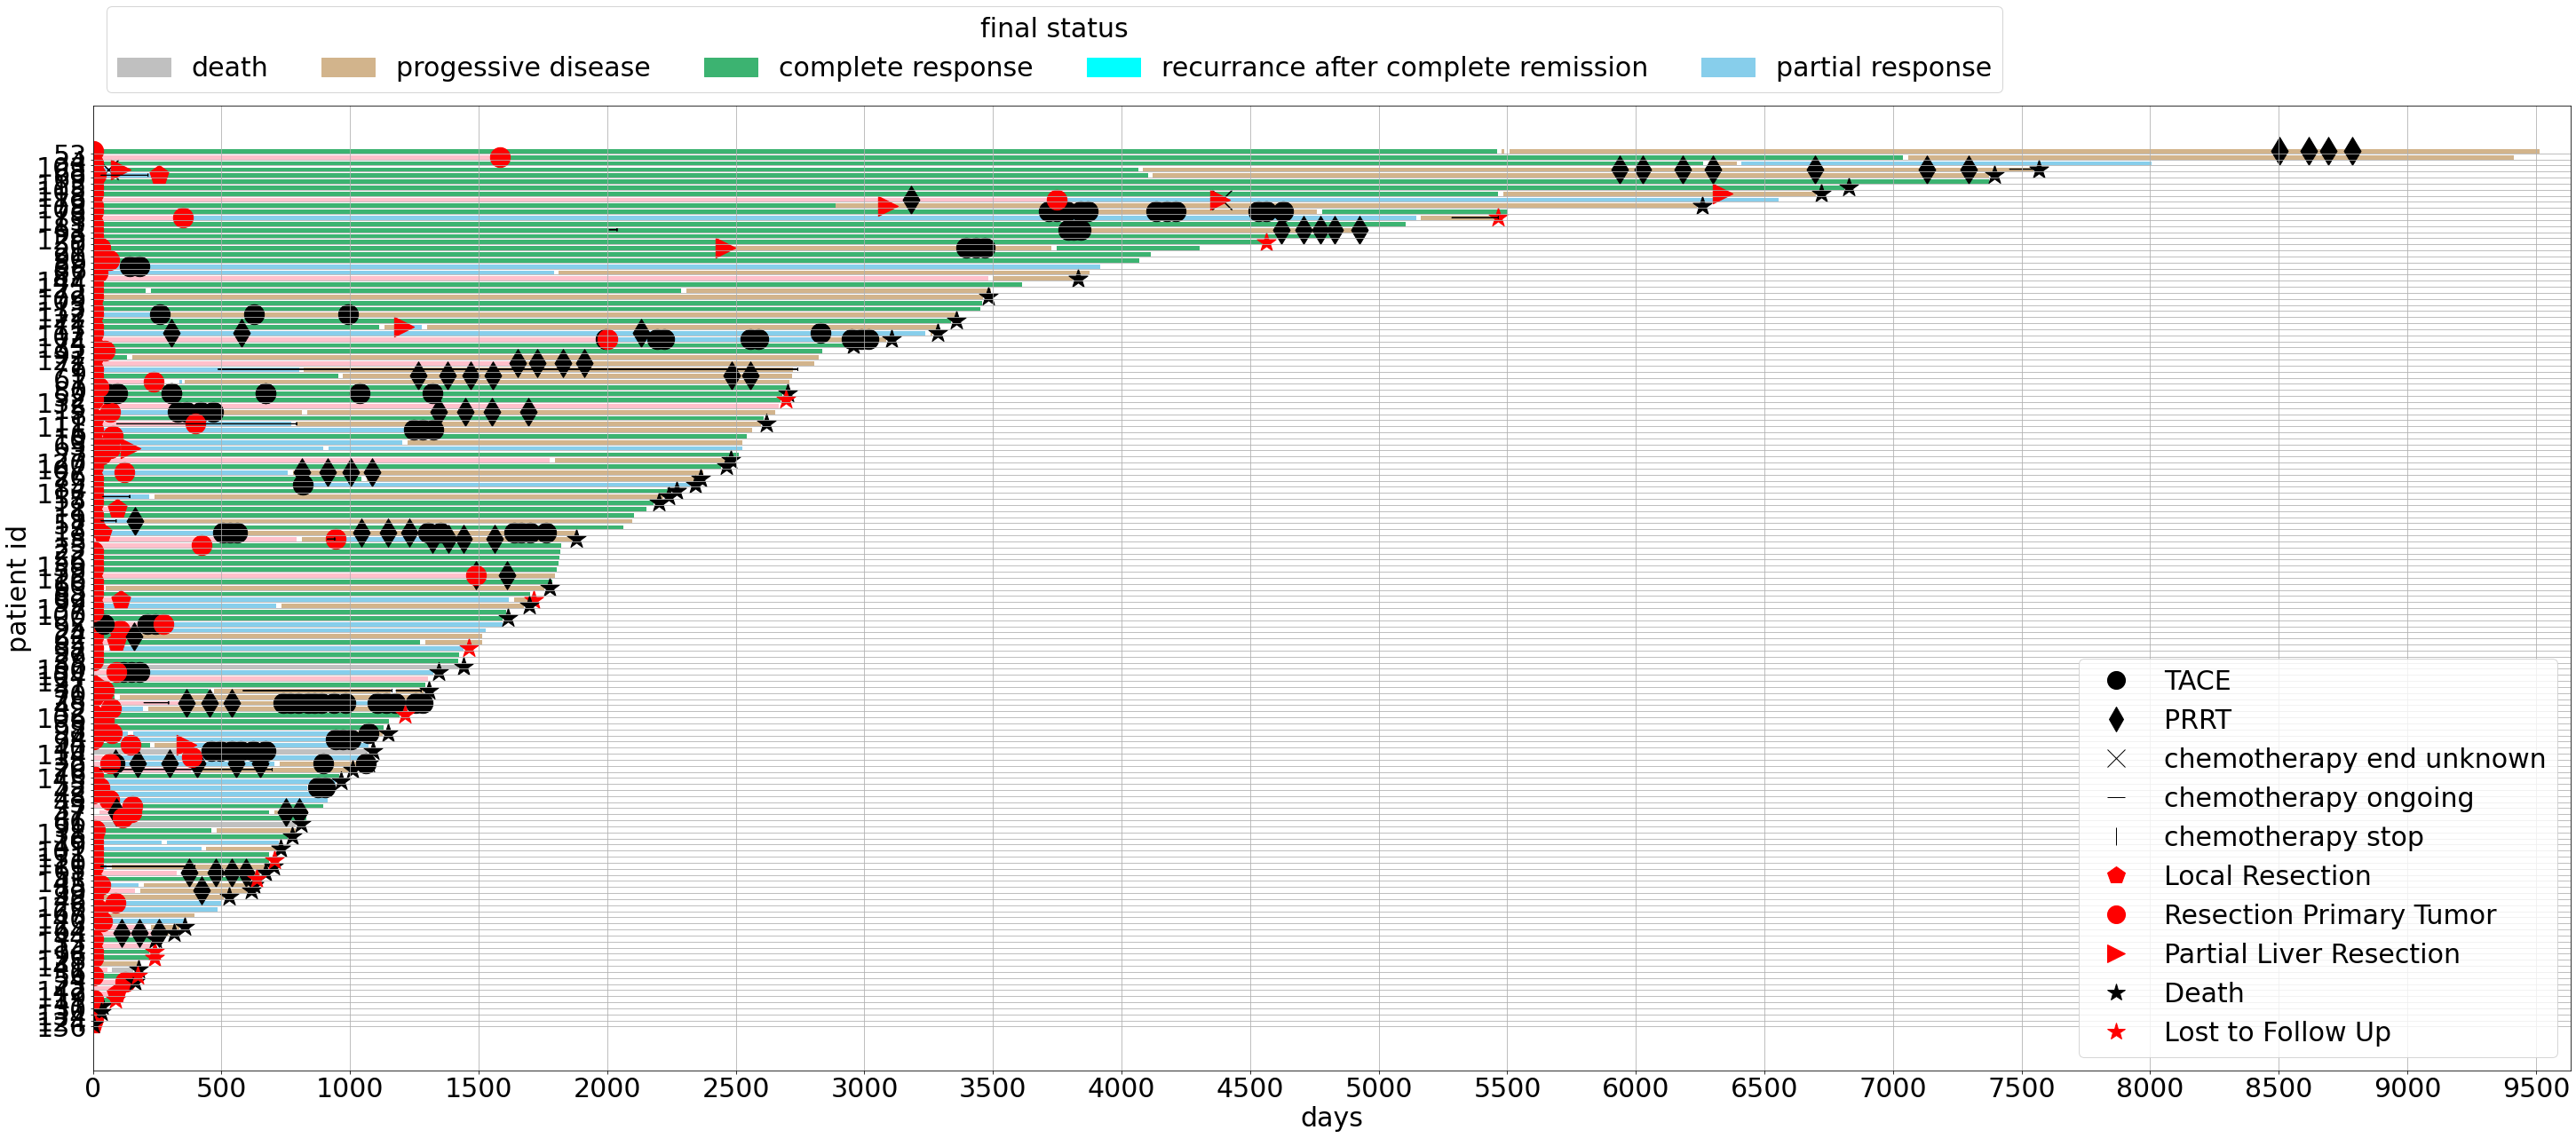

In [25]:
# Loop over the cohorts an save the graphes
for therapyseq in dict_cohorts.keys():

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (50,20)

    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 30}

    plt.rc('font', **font)


    plot_bars(therapyseq,'Stop_Tage')

    #Legend

    # Add first legend:  only labeled data is included
    leg1 = plt.legend(ncol = 8, title='final status', handles=patches, bbox_to_anchor=(0, 1), loc='lower left')
    #plt.legend(handles=regiments)
    # Add second legend
    # leg1 will be removed from figure
    leg2 = ax.legend(handles=regiments, loc='lower right')
    # Manually add the first legend back
    ax.add_artist(leg1)

    plt.savefig(f'graphics/therapyseq{therapyseq}.png')
    plt.show()